In [1]:
# AI-Based Wage Gap Detection in Indian Industries

import pandas as pd
import numpy as np

# ML & preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Evaluation
from sklearn.metrics import mean_absolute_error, r2_score

# Save model
import joblib

In [3]:
df = pd.read_csv("dataset.csv")

print(df.shape)
df.head(10)


(10000, 22)


,Worker_ID,Industry,Skill_Level,Education_Level,Experience_Years,Employment_Type,Contract_Type,Working_Hours_Per_Day,Overtime_Hours,Productivity_Score,...,Cost_of_Living_Index,Minimum_Wage_Legal,Law_Revision_Year,Enforcement_Level,Actual_Wage,Written_Contract,Fair_Wage_AI,Wage_Gap,Gap_Severity,Likely_Law_Gap
0,50001,MSME Manufacturing,Unskilled,Diploma,3.0,Permanent,Daily,10.0,2.0,82.0,...,0.88,NaN,NaN,NaN,509.0,No,NaN,NaN,NaN,NaN
1,50002,Leather,Unskilled,NaN,9.0,Contract,Verbal,NaN,NaN,59.0,...,0.82,595.0,2010.0,Strong,516.0,No,658.0,142.0,Severe,Outdated minimum wage
2,50003,Leather,Skilled,NaN,NaN,Contract,Contractor,9.0,1.0,51.0,...,0.82,490.0,2015.0,Strong,299.0,NaN,NaN,NaN,NaN,NaN
3,50004,Silk,Semi-skilled,ITI,18.0,Contract,Verbal,10.0,2.0,64.0,...,1.25,NaN,NaN,NaN,342.0,No,NaN,NaN,NaN,NaN
4,50005,Leather,Semi-skilled,ITI,9.0,Permanent,Verbal,8.0,0.0,52.0,...,0.85,377.0,2018.0,Weak,363.0,No,506.0,143.0,Severe,Outdated minimum wage
5,50006,MSME Manufacturing,Unskilled,NaN,7.0,Permanent,Verbal,8.0,0.0,48.0,...,1.15,595.0,2016.0,Strong,768.0,No,875.0,107.0,Serious,Skill premium ignored
6,50007,Leather Tannery,Skilled,NaN,NaN,Contract,Verbal,9.0,1.0,92.0,...,1.10,500.0,2019.0,Weak,504.0,No,NaN,NaN,NaN,NaN
7,50008,Silk,Skilled,Secondary,4.0,Permanent,Verbal,12.0,4.0,62.0,...,0.88,418.0,2019.0,Medium,324.0,No,556.0,232.0,Severe,Weak enforcement
8,50009,Leather,Unskilled,NaN,NaN,Contract,Verbal,10.0,2.0,84.0,...,0.78,533.0,2010.0,Weak,649.0,No,NaN,NaN,NaN,NaN
9,50010,MSME Engineering,Semi-skilled,ITI,1.0,Permanent,Daily,9.0,1.0,49.0,...,1.10,383.0,2020.0,Weak,388.0,No,567.0,179.0,Severe,Outdated minimum wage


In [4]:
# =========================================================
# 2. Handle Categorical NULLs (Domain-Aware)
# =========================================================

categorical_cols = [
    "Industry", "Skill_Level", "Education_Level",
    "Employment_Type", "Contract_Type",
    "Region_Type", "State", "Enforcement_Level",
    "Written_Contract"
]

df[categorical_cols] = df[categorical_cols].fillna("Unknown")

In [5]:
# =========================================================
# 3. Add Missingness Indicators (Important for Informality)
# =========================================================

df["Skill_Missing"] = (df["Skill_Level"] == "Unknown").astype(int)
df["Enforcement_Missing"] = (df["Enforcement_Level"] == "Unknown").astype(int)

In [6]:
# =========================================================
# 4. Numerical Imputation (Rule-Based, NOT Global Mean)
# =========================================================

df["Experience_Years"] = df.groupby("Skill_Level")["Experience_Years"]\
    .transform(lambda x: x.fillna(x.median()))

df["Working_Hours_Per_Day"] = df.groupby("Industry")["Working_Hours_Per_Day"]\
    .transform(lambda x: x.fillna(x.median()))

df["Productivity_Score"] = df.groupby("Skill_Level")["Productivity_Score"]\
    .transform(lambda x: x.fillna(x.median()))

df["Minimum_Wage_Legal"] = df.groupby("State")["Minimum_Wage_Legal"]\
    .transform(lambda x: x.fillna(x.median()))

df["Law_Revision_Year"] = df.groupby("State")["Law_Revision_Year"]\
    .transform(lambda x: x.fillna(x.mode()[0]))

c:\Users\rasgu\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [7]:
# =========================================================
# 5. Drop Rows Where Target Cannot Be Learned
# =========================================================

df = df.dropna(subset=["Actual_Wage", "Fair_Wage_AI"])

print("After cleaning:", df.shape)

After cleaning: (5199, 24)


In [8]:
# =========================================================
# 6. Feature Selection
# =========================================================

features = [
    "Industry", "Skill_Level", "Education_Level",
    "Experience_Years", "Employment_Type",
    "Contract_Type", "Working_Hours_Per_Day",
    "Overtime_Hours", "Productivity_Score",
    "Region_Type", "State",
    "Cost_of_Living_Index",
    "Minimum_Wage_Legal", "Law_Revision_Year",
    "Enforcement_Level", "Written_Contract",
    "Skill_Missing", "Enforcement_Missing"
]

X = df[features]
y = df["Fair_Wage_AI"]

In [9]:
# =========================================================
# 7. Train-Test Split
# =========================================================

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [17]:
# =========================================================
# 8. Preprocessing Pipeline
# =========================================================

num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object"]).columns

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ]
)


In [18]:
# =========================================================
# 9. Models to Compare
# =========================================================

models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(
        n_estimators=200, max_depth=12, random_state=42
    ),
    "Gradient Boosting": GradientBoostingRegressor(
        n_estimators=300, learning_rate=0.05, max_depth=4, random_state=42
    )
}

results = []
trained_models = {}

In [19]:
# =========================================================
# 10. Train & Evaluate Models
# =========================================================

for name, model in models.items():
    pipe = Pipeline([
        ("preprocessing", preprocessor),
        ("model", model)
    ])

    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)

    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    results.append({
        "Model": name,
        "MAE": mae,
        "R2": r2
    })

    trained_models[name] = pipe

results_df = pd.DataFrame(results).sort_values(by="MAE")
print("\nModel Comparison:")
print(results_df)


Model Comparison:
               Model        MAE        R2
2  Gradient Boosting   6.564826  0.997203
0  Linear Regression  12.079639  0.988824
1      Random Forest  17.746148  0.980471


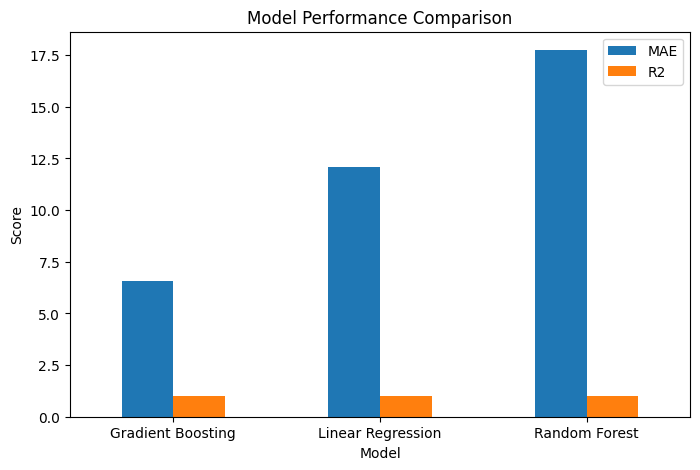

In [20]:
import matplotlib.pyplot as plt

results_df.plot(
    x="Model",
    y=["MAE", "R2"],
    kind="bar",
    figsize=(8,5)
)

plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.show()


In [28]:
# Identify best model again from results_df
best_model_name = results_df.iloc[0]["Model"]
best_model = trained_models[best_model_name]

print("Best model reloaded:", best_model_name)


Best model reloaded: Gradient Boosting


In [29]:
# Recompute predictions using the best model
y_pred = best_model.predict(X_test)


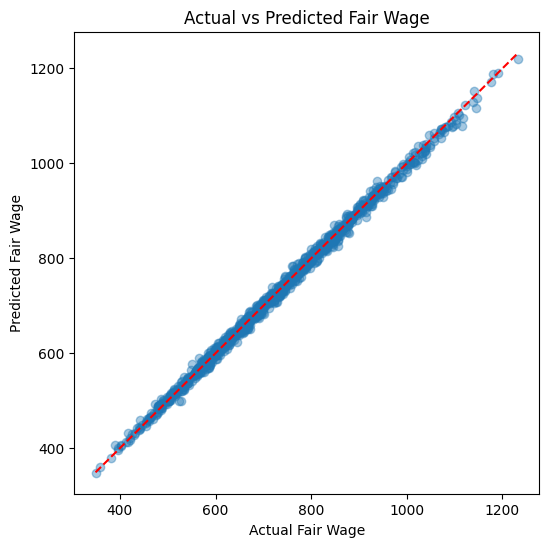

In [30]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.4)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    'r--'
)
plt.xlabel("Actual Fair Wage")
plt.ylabel("Predicted Fair Wage")
plt.title("Actual vs Predicted Fair Wage")
plt.show()


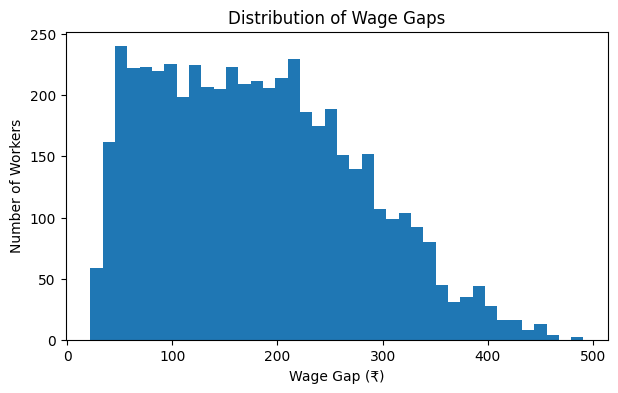

In [ ]:
plt.figure(figsize=(7,4))
plt.hist(df["Wage_Gap"], bins=40)
plt.xlabel("Wage Gap (₹)")
plt.ylabel("Number of Workers")
plt.title("Distribution of Wage Gaps")
plt.show()


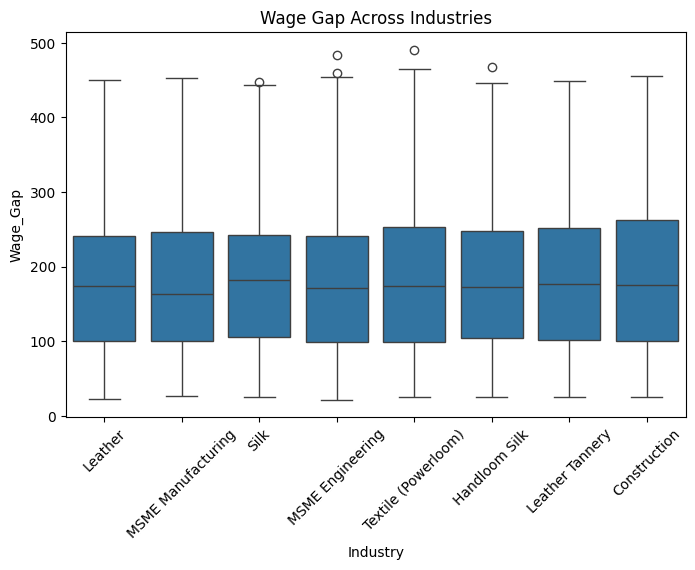

In [ ]:
import seaborn as sns

plt.figure(figsize=(8,5))
sns.boxplot(x="Industry", y="Wage_Gap", data=df)
plt.xticks(rotation=45)
plt.title("Wage Gap Across Industries")
plt.show()



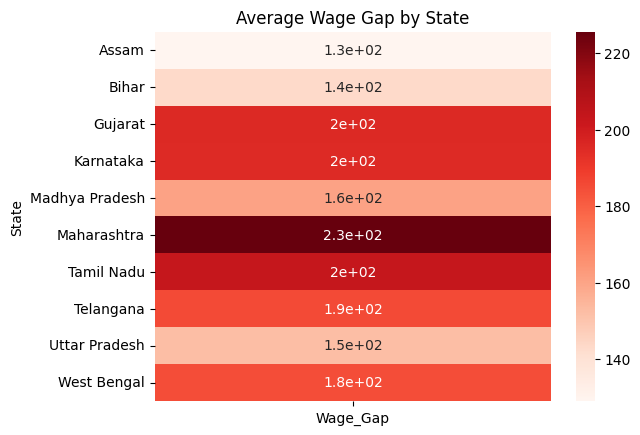

In [ ]:
pivot = df.pivot_table(
    values="Wage_Gap",
    index="State",
    aggfunc="mean"
)

sns.heatmap(pivot, annot=True, cmap="Reds")
plt.title("Average Wage Gap by State")
plt.show()


In [32]:
#testing sample data

# Sample test cases
test_data = pd.DataFrame([
    {
        "Industry": "Construction",
        "Skill_Level": "Unskilled",
        "Education_Level": "Primary",
        "Experience_Years": 5,
        "Employment_Type": "Contract",
        "Contract_Type": "Daily",
        "Working_Hours_Per_Day": 10,
        "Overtime_Hours": 2,
        "Productivity_Score": 55,
        "Region_Type": "Rural",
        "State": "Bihar",
        "Cost_of_Living_Index": 0.82,
        "Minimum_Wage_Legal": 350,
        "Law_Revision_Year": 2012,
        "Enforcement_Level": "Weak",
        "Written_Contract": "No",
        "Skill_Missing": 0,
        "Enforcement_Missing": 0,
        "Actual_Wage": 280
    },
    {
        "Industry": "Silk",
        "Skill_Level": "Semi-skilled",
        "Education_Level": "Secondary",
        "Experience_Years": 7,
        "Employment_Type": "Permanent",
        "Contract_Type": "Written",
        "Working_Hours_Per_Day": 8,
        "Overtime_Hours": 0,
        "Productivity_Score": 70,
        "Region_Type": "Urban",
        "State": "Karnataka",
        "Cost_of_Living_Index": 1.10,
        "Minimum_Wage_Legal": 420,
        "Law_Revision_Year": 2018,
        "Enforcement_Level": "Medium",
        "Written_Contract": "Yes",
        "Skill_Missing": 0,
        "Enforcement_Missing": 0,
        "Actual_Wage": 390
    },
    {
        "Industry": "Leather",
        "Skill_Level": "Skilled",
        "Education_Level": "Diploma",
        "Experience_Years": 11,
        "Employment_Type": "Contract",
        "Contract_Type": "Contractor",
        "Working_Hours_Per_Day": 9,
        "Overtime_Hours": 1,
        "Productivity_Score": 85,
        "Region_Type": "Urban",
        "State": "Tamil Nadu",
        "Cost_of_Living_Index": 1.15,
        "Minimum_Wage_Legal": 480,
        "Law_Revision_Year": 2015,
        "Enforcement_Level": "Medium",
        "Written_Contract": "Yes",
        "Skill_Missing": 0,
        "Enforcement_Missing": 0,
        "Actual_Wage": 450
    }
])


In [34]:
# Predict fair wages
test_data["Predicted_Fair_Wage"] = best_model.predict(
    test_data.drop(columns=["Actual_Wage"])
)

# Compute wage gap
test_data["Wage_Gap"] = (
    test_data["Predicted_Fair_Wage"] - test_data["Actual_Wage"]
)

test_data


,Industry,Skill_Level,Education_Level,Experience_Years,Employment_Type,Contract_Type,Working_Hours_Per_Day,Overtime_Hours,Productivity_Score,Region_Type,...,Cost_of_Living_Index,Minimum_Wage_Legal,Law_Revision_Year,Enforcement_Level,Written_Contract,Skill_Missing,Enforcement_Missing,Actual_Wage,Predicted_Fair_Wage,Wage_Gap
0,Construction,Unskilled,Primary,5,Contract,Daily,10,2,55,Rural,...,0.82,350,2012,Weak,No,0,0,280,419.661642,139.661642
1,Silk,Semi-skilled,Secondary,7,Permanent,Written,8,0,70,Urban,...,1.10,420,2018,Medium,Yes,0,0,390,713.575220,323.575220
2,Leather,Skilled,Diploma,11,Contract,Contractor,9,1,85,Urban,...,1.15,480,2015,Medium,Yes,0,0,450,921.632909,471.632909


In [35]:
comparison = test_data[
    ["Industry", "Skill_Level", "State",
     "Actual_Wage", "Predicted_Fair_Wage", "Wage_Gap"]
]

comparison


,Industry,Skill_Level,State,Actual_Wage,Predicted_Fair_Wage,Wage_Gap
0,Construction,Unskilled,Bihar,280,419.661642,139.661642
1,Silk,Semi-skilled,Karnataka,390,713.575220,323.575220
2,Leather,Skilled,Tamil Nadu,450,921.632909,471.632909


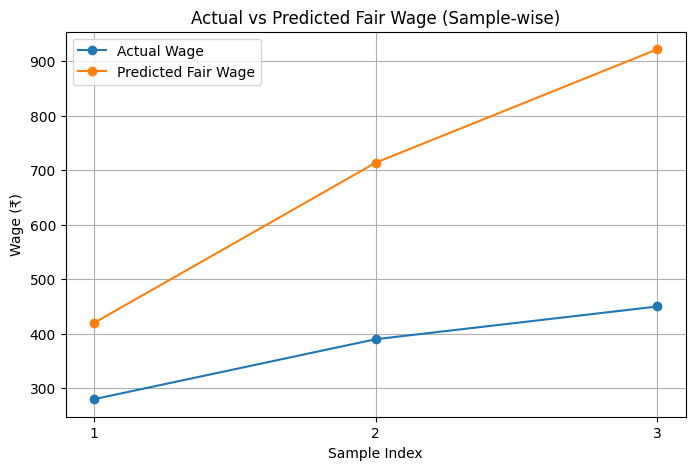

In [ ]:
import matplotlib.pyplot as plt

# Create an index for samples
test_data = test_data.reset_index(drop=True)
test_data["Sample_ID"] = test_data.index + 1

plt.figure(figsize=(8,5))

plt.plot(
    test_data["Sample_ID"],
    test_data["Actual_Wage"],
    marker="o",
    label="Actual Wage"
)

plt.plot(
    test_data["Sample_ID"],
    test_data["Predicted_Fair_Wage"],
    marker="o",
    label="Predicted Fair Wage"
)

plt.xlabel("Sample Index")
plt.ylabel("Wage (₹)")
plt.title("Actual vs Predicted Fair Wage (Sample-wise)")
plt.xticks(test_data["Sample_ID"])
plt.legend()
plt.grid(True)  
plt.show()
